In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,7

In [2]:
df = pd.read_csv('Light_Rail_Patronage.csv')

## Preprocessing

In [3]:
df1 = df.copy()
# preprocessing
df1.index = pd.to_datetime(df1['Date'],format="%d/%m/%Y")
df1.drop(columns=['Date'],inplace=True)
df1 = df1.sort_values(by=['Date'])

In [4]:
df2 = df1.asfreq('d')
df2.loc['2019-12-25'] = 1000 #manually fixing 

In [5]:
train = df2[:-7]
test = df2[-7:]

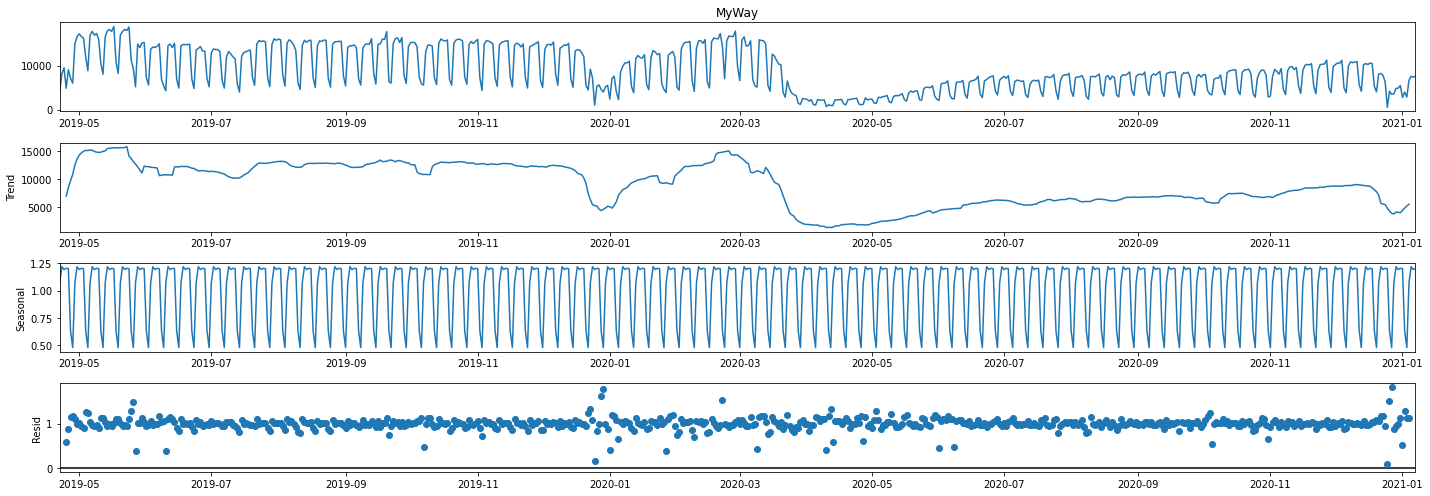

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train['MyWay'], model='multiplicative',period=7)
result.plot()
plt.show()

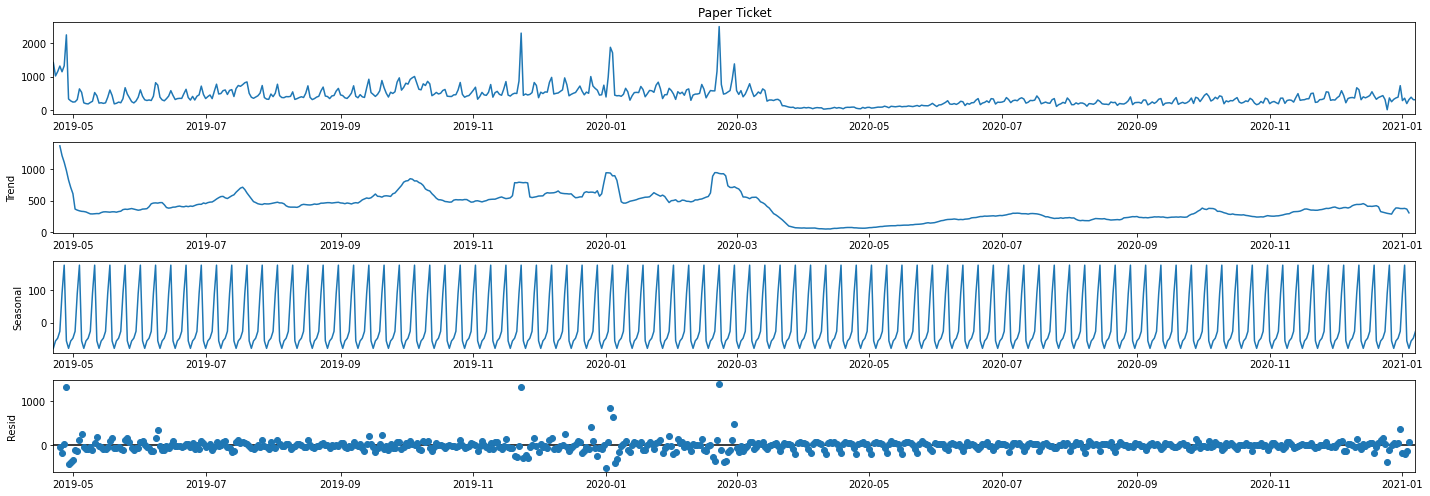

In [7]:
result = seasonal_decompose(train['Paper Ticket'], model='additive',period=7)
result.plot()
plt.show()

## Exponential Smoothing Model
### MyWay Prediction

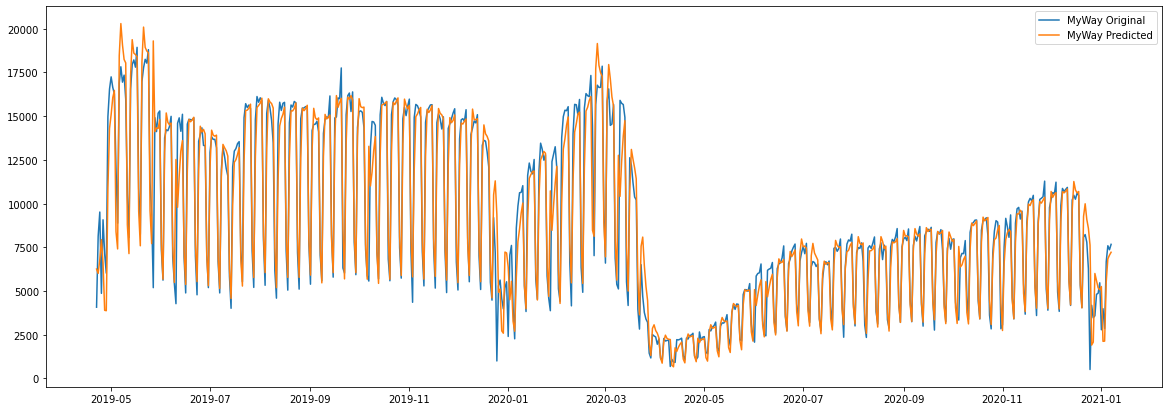

In [8]:
from statsmodels.tsa.api import ExponentialSmoothing as ES
myway_model = ES(train['MyWay'].dropna() ,seasonal_periods=7 ,
                 trend='add', seasonal='mul', initialization_method='estimated', use_boxcox=True)
myway_fit = myway_model.fit()
myway_predicted = myway_fit.predict(start=train.index[0])

plt.plot(train['MyWay'],label='MyWay Original')
plt.plot(myway_predicted,label='MyWay Predicted')
plt.legend()
plt.show()

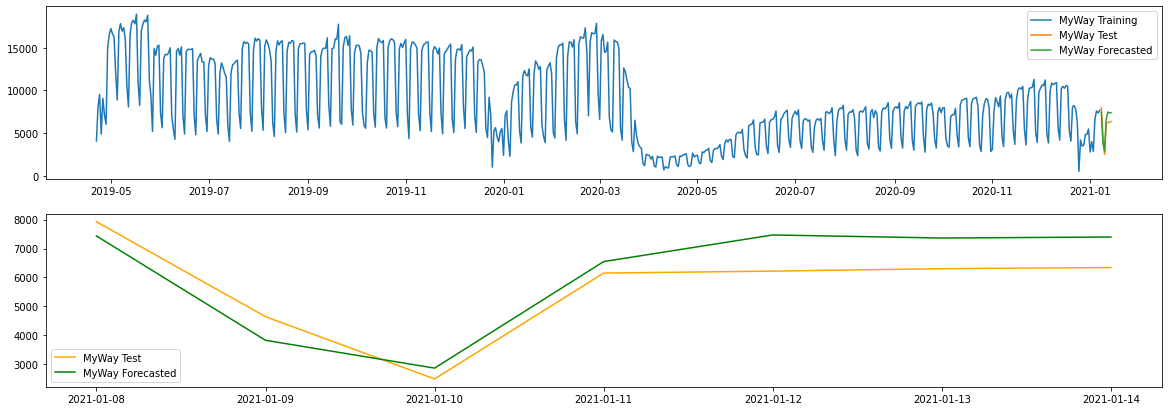

In [9]:
myway_forecast = myway_fit.forecast(len(test))
plt.subplot(2,1,1)
plt.plot(train['MyWay'],label='MyWay Training')
plt.plot(test['MyWay'],label='MyWay Test')
plt.plot(myway_forecast,label='MyWay Forecasted')
plt.legend()
plt.subplot(2,1,2)
plt.plot(test['MyWay'],label='MyWay Test',color='orange')
plt.plot(myway_forecast,label='MyWay Forecasted',color='green')
plt.legend()
plt.show()

In [10]:
myway_fit.forecast(len(test))

2021-01-08    7433.656211
2021-01-09    3831.986437
2021-01-10    2871.714138
2021-01-11    6549.731151
2021-01-12    7468.100986
2021-01-13    7362.391007
2021-01-14    7398.069933
Freq: D, dtype: float64

### Paper Ticket Prediction

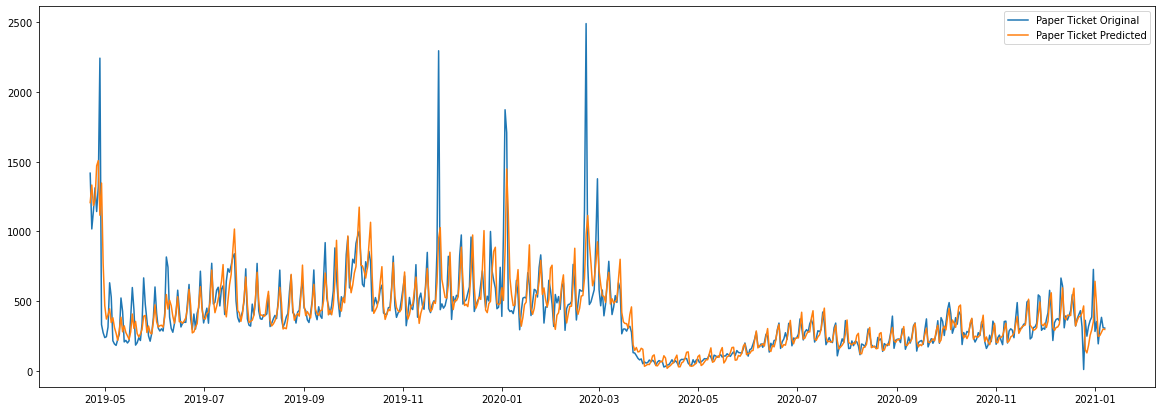

In [27]:
ticket_model = ES(train['Paper Ticket'].dropna() ,seasonal_periods=28 ,
                  trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True)
ticket_fit = ticket_model.fit()
ticket_predicted = ticket_fit.predict(start=train.index[0])

plt.plot(train['Paper Ticket'],label='Paper Ticket Original')
plt.plot(ticket_predicted,label='Paper Ticket Predicted')
plt.legend()
plt.show()

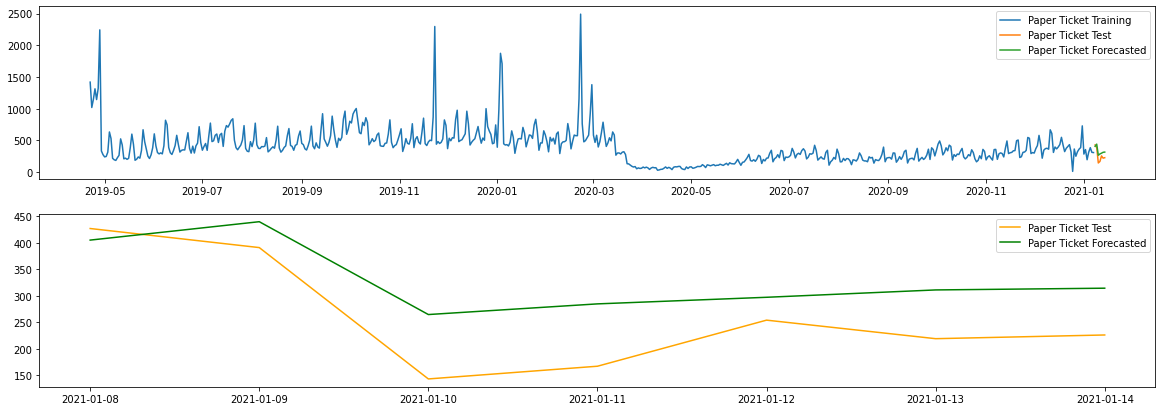

In [28]:
ticket_forecast = ticket_fit.forecast(len(test))
plt.subplot(2,1,1)
plt.plot(train['Paper Ticket'],label='Paper Ticket Training')
plt.plot(test['Paper Ticket'],label='Paper Ticket Test')
plt.plot(ticket_forecast,label='Paper Ticket Forecasted')
plt.legend()
plt.subplot(2,1,2)
plt.plot(test['Paper Ticket'],label='Paper Ticket Test',color='orange')
plt.plot(ticket_forecast,label='Paper Ticket Forecasted',color='green')
plt.legend()
plt.show()

In [29]:
ticket_forecast

2021-01-08    405.125997
2021-01-09    439.867545
2021-01-10    264.573815
2021-01-11    284.710383
2021-01-12    297.164389
2021-01-13    311.035901
2021-01-14    314.320889
Freq: D, dtype: float64

## Training vs Test Comparision (Total Patronage)

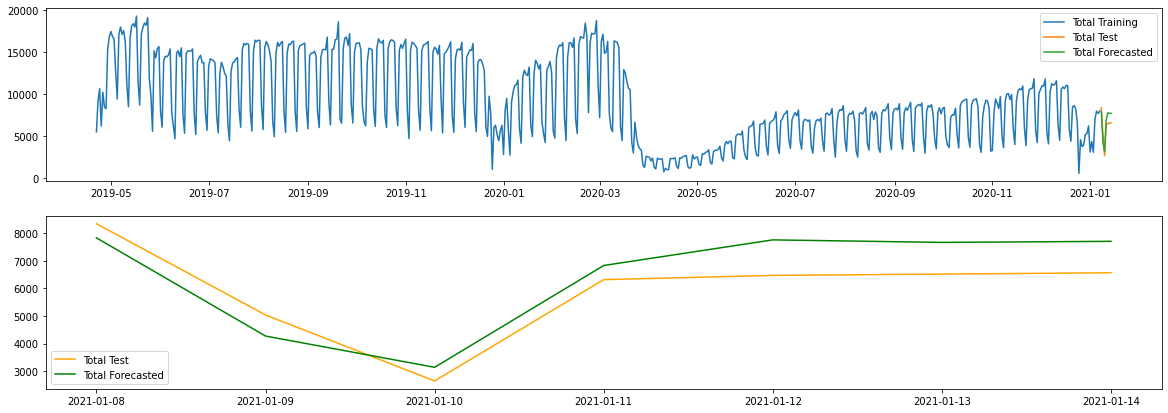

In [30]:
total_forecast = myway_forecast + ticket_forecast
plt.subplot(2,1,1)
plt.plot(train['Total'],label='Total Training')
plt.plot(test['Total'],label='Total Test')
plt.plot(total_forecast,label='Total Forecasted')
plt.legend()
plt.subplot(2,1,2)
plt.plot(test['Total'],label='Total Test',color='orange')
plt.plot(total_forecast,label='Total Forecasted',color='green')
plt.legend()
plt.show()

In [31]:
result = pd.DataFrame(test.MyWay,columns=['MyWay'],index=test.index)
result['Predicted MyWay'] = myway_forecast.astype(int)
result['Paper Ticket'] = test['Paper Ticket']
result['Predicted Paper Ticket'] = ticket_forecast.astype(int)
result['Total'] = test['Total']
result['Predicted Total'] = result['Predicted MyWay'] + result['Predicted Paper Ticket']
result

,MyWay,Predicted MyWay,Paper Ticket,Predicted Paper Ticket,Total,Predicted Total
Date,,,,,,
2021-01-08,7926.0,7433,427.0,405,8353.0,7838
2021-01-09,4647.0,3831,391.0,439,5038.0,4270
2021-01-10,2498.0,2871,143.0,264,2641.0,3135
2021-01-11,6153.0,6549,167.0,284,6320.0,6833
2021-01-12,6220.0,7468,254.0,297,6474.0,7765
2021-01-13,6304.0,7362,219.0,311,6523.0,7673
2021-01-14,6344.0,7398,226.0,314,6570.0,7712


## Model Accuracy & Error Percentage

In [32]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
mape = mean_absolute_percentage_error(test.Total,result['Predicted Total'])
rmse = np.sqrt(mean_squared_error(test.Total,result['Predicted Total']))
corr = result['Total'].corr(result['Predicted Total'])
print('Correlation Between Total Patronage & Predicted Total patronage:',corr)
print('Accuracy: ~{:.2%}'.format(corr))
print('Root Mean Squared Error:',rmse)
print('R2 Score:',r2_score(test.Total,result['Predicted Total']))
print('Mean Absolute Percentage Error: {:.2%}'.format(mape))

Correlation Between Total Patronage & Predicted Total patronage: 0.9050662032976982
Accuracy: ~90.51%
Root Mean Squared Error: 898.8563368446119
R2 Score: 0.6970674907904804
Mean Absolute Percentage Error: 14.74%


## Prediction For Next 7 Days

In [33]:
f_myway_model = ES(df2['MyWay'].dropna() ,seasonal_periods=7 ,trend='add',
                   seasonal='mul', initialization_method='estimated', use_boxcox=True)
f_myway_fit = f_myway_model.fit()
f_myway_forecast = f_myway_fit.forecast(7)

f_ticket_model = ES(df2['Paper Ticket'].dropna() ,seasonal_periods=28 ,
                    trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True)
f_ticket_fit = f_ticket_model.fit()
f_ticket_forecast = f_ticket_fit.forecast(7)


In [34]:
f_result = pd.DataFrame(f_myway_forecast.astype(int),columns=['MyWay'])
f_result['Paper Ticket'] = f_ticket_forecast.astype(int)
f_result['Total'] = f_result['MyWay'] + f_result['Paper Ticket']
f_result

,MyWay,Paper Ticket,Total
2021-01-15,6265,302,6567
2021-01-16,3436,321,3757
2021-01-17,2525,194,2719
2021-01-18,5565,224,5789
2021-01-19,6341,243,6584
2021-01-20,6208,242,6450
2021-01-21,6245,238,6483
